# ProperImage con DES Cluster Simulation

Vamos a ver como usamos a ProperImage para analizar la PSF de las simulaciones de **DES**.

Para eso es importante primero clonar a ProperImage:

`git clone git@github.com:toros-astro/ProperImage.git`

y luego realizar la instalacion de properimage en nuestro sistema.

Es simplemente moverse al lugar donde esta clonado, y hacer lo siguiente:


`pip install -e .`

Con esto ya podremos entrar a una terminal IPython e importar los modulos de *properimage*

In [1]:
import os

import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

%matplotlib inline

#librerias propias
import psf_DES
import test_psf_DES
from properimage import propercoadd as pc
from properimage import utils

In [2]:
from astropy.convolution import convolve

In [3]:
from astropy.nddata.utils import extract_array

## Abriendo una de las imagenes

Vamos a ver como abrir una imagen de **DES Cluster Simulation**

In [4]:
image_path = os.path.abspath('./../imagenes-LN-PSF/im_06_6.fits')

img = fits.getdata(image_path)

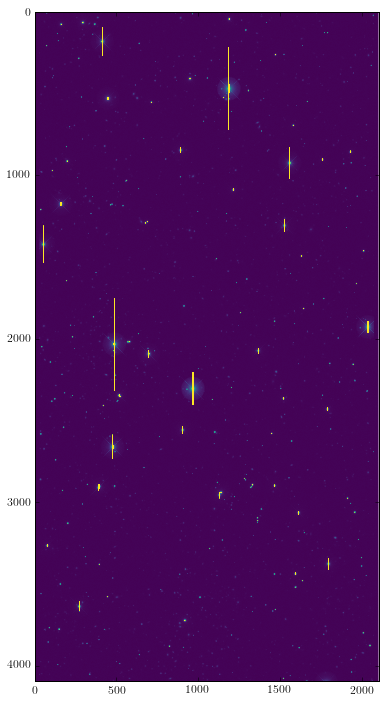

In [5]:
plt.figure(figsize=(8,12))
plt.imshow(np.log10(img), interpolation='none', cmap='viridis')

Como se puede ver la imagen es grande, y posee estrellas saturadas.

Para trabajar con ProperImage es necesario trabajar con instancias del objeto `SingleImage`.

Este objeto esta modificado mediante herencia para DES y se llama en cambio `psf_DES.SingleImageDES`.
Ademas, para trabajar con DES se deben setear parametros importantes, que se relacionan con sextractor:


In [6]:
seeing_par = {}
seeing_par['pixsize'] = 0.27
seeing_par['run'] = 33
seeing_par['filter'] = 'R'
seeing_par['magmax'] = 23.
seeing_par['magmin'] = 18.
seeing_par['fwhmmax'] = 4.5
seeing_par['plot'] = None
seeing_par['img'] = image_path

In [7]:
image = psf_DES.SingleImageDES(seeing_par=seeing_par, img=image_path)

## Extraer una autopsf

Realizar esta operacion es bastante simple, y solo hay un parametro que tal vez queremos modificar.
Dentro del calculo de psf se extraen parches donde estan las mejores estrellas ($P^*_i$), y se generan componentes principales, utilizando una matriz de correlacion $C_{ij} = <P^*_i, P^*_j>$.

Esta matriz genera los autovalores $\lambda_i$ y autovectores $\omega_i$.

El valor de rechazo para los autovalores se impone de forma tal que si $\Lambda = \sum\limits_{j=1} |\lambda_j|$

$\lambda_i / \Lambda > \texttt{pow_th}$

In [8]:
a_fields, psf_basis = image.get_variable_psf(pow_th=0.01)

 
 ------------ seeing:  0.84105
 ------------ imagen:  /home/bruno/Devel/DESCSimulation/imagenes-LN-PSF/im_06_6.fits
 
cantidad de estrellas seleccionadas:  223
cantidad de galaxias seleccionadas:  1568
Sources good to calculate = 223
background subtracted image obtained
background subtracted image obtained
returning best sources
Fitshape = (13, 13)
returning Covariance Matrix
obtainig KL basis, using k = 1
returning variable psf


Para graficar los resultados, podemos utilizar las funciones del modulo **utils** de ProperImage:

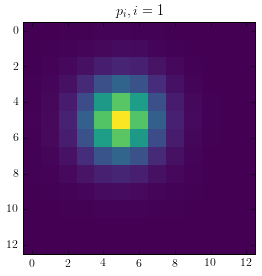

In [9]:
utils.plot_psfbasis(psf_basis=psf_basis, nbook=True)

In [10]:
utils.plot_afields(a_fields=a_fields, shape=img.shape, nbook=True)

No a_fields were calculated. Only one Psf Basis


Como pusimos un $\texttt{pow_th}$ demasiado alto, unicamente una **psf** fue estimada.

Podemos probar con un corte mas relajado; y a la vez introducir una cualidad extra de Properimage: el **contexto**

Esto significa que si queremos limpiar los archivos adicionales que debimos calcular para la imagen anterior debemos ejecutar la siguiente celda:

In [11]:
image._clean()

cleaning... 


En cambio, esto puede ser manejado simplemente con un generador de contexto de Python:

In [12]:
image_path = os.path.abspath('./../imagenes-LN-PSF/im_06_6.fits')

In [19]:
with psf_DES.SingleImageDES(seeing_par=seeing_par, img=image_path) as image:
    a_fields, psf_basis = image.get_variable_psf(pow_th=0.0001)
    gxs = image._gxs

 
 ------------ seeing:  0.84105
 ------------ imagen:  /home/bruno/Devel/DESCSimulation/imagenes-LN-PSF/im_06_6.fits
 
cantidad de estrellas seleccionadas:  223
cantidad de galaxias seleccionadas:  1568
Sources good to calculate = 223
background subtracted image obtained
background subtracted image obtained
returning best sources
Fitshape = (13, 13)
returning Covariance Matrix
obtainig KL basis, using k = 4
obtaining a fields
returning variable psf
cleaning... 


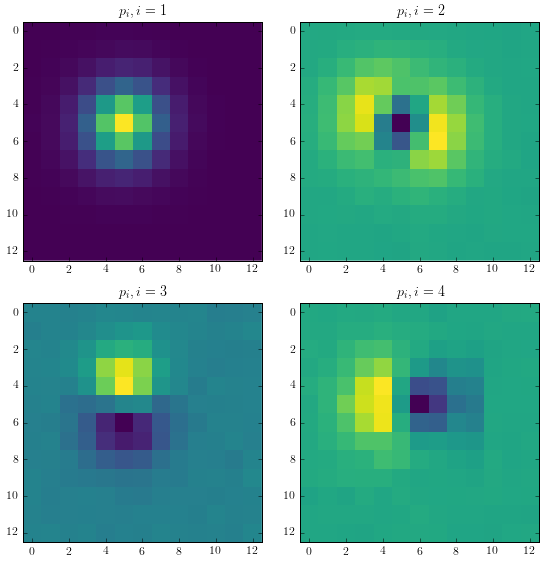

In [20]:
utils.plot_psfbasis(psf_basis=psf_basis, nbook=True)

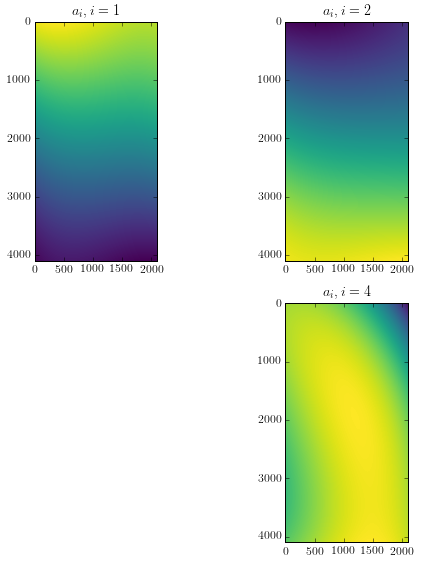

In [21]:
utils.plot_afields(a_fields=a_fields, shape=img.shape, nbook=True)

In [57]:
from astropy.modeling import models, fitting
def get_single_psf(x, y, a_fields, psf_basis):
    s = np.zeros_like(psf_basis[0])
    
    for i in range(len(psf_basis)):
        s += psf_basis[i]*a_fields[i](x,y)
    
    x, y = np.mgrid[:s.shape[0], :s.shape[1]]
    g2 = models.Gaussian2D(x_stddev=1, y_stddev=1, 
                           x_mean=s.shape[0]/2, 
                           y_mean=s.shape[1]/2)
    fitter = fitting.LevMarLSQFitter()
    
    return fitter(g2, x, y, s) 
        

In [58]:
p = get_single_psf(1115, 2145, a_fields, psf_basis)

In [59]:
p

<Gaussian2D(amplitude=0.08176217681933898, x_mean=4.995844007429285, y_mean=5.0172526793840735, x_stddev=1.3080192535143431, y_stddev=1.388316366698078, theta=4.33650053638434)>

In [64]:
from astropy.io import ascii
from astropy.table import Table, Row

In [30]:
gxs.write('galaxias_im06_6.cat', format='ascii.tab_no_header')

In [65]:
lines = []
for row in gxs:
    p = get_single_psf(row['X_IMAGE'], row['Y_IMAGE'], a_fields, psf_basis)
    sx = p.x_stddev
    sy = p.y_stddev
    th = p.theta
    
    a = 2*max([sx, sy])
    b = 2*min([sx, sy])
    
    ellip = (a - b)/float(a + b)
    
    lines.append([row['X_IMAGE'], row['Y_IMAGE'], 0., 0., ellip, th-np.pi/4., a*b, 1.])
    

PSFs = Table(rows=lines, names=('x', 'y', 'zero1', 'zero2', 'ellip', 'theta', 'a_times_b', 'one'))

In [67]:
PSFs.write('PSFS_im06_6.dat', format='ascii.tab')

In [48]:
float(a-b)/float(a+b)

0.029780088421414306

In [68]:
len(PSFs)

1568

In [ ]:
reload(utils)

In [ ]:
%%time
deconvolved = utils.lucy_rich(img, psf_basis, a_fields, clip=True, iterations=5)

In [ ]:
plt.figure(figsize=(16, 24))
plt.imshow(np.log10(deconvolved), interpolation='none', cmap='viridis')
plt.colorbar()

In [ ]:
%%time
deconvolved10 = utils.lucy_rich(img, psf_basis, a_fields, clip=True, iterations=10)

In [ ]:
%%time
deconvolved15 = utils.lucy_rich(img, psf_basis, a_fields, clip=True, iterations=15)

In [ ]:
%%time
deconvolved20 = utils.lucy_rich(img, psf_basis, a_fields, clip=True, iterations=20)

In [ ]:
%%time
deconvolved25 = utils.lucy_rich(img, psf_basis, a_fields, clip=True, iterations=25)

In [ ]:
%%time
deconvolved50 = utils.lucy_rich(img, psf_basis, a_fields, clip=True, iterations=50)

In [ ]:
plt.figure(figsize=(16, 24))
plt.imshow(np.log10(deconvolved50), interpolation='none', cmap='viridis')
plt.colorbar()

In [ ]:
a = np.zeros_like(img)


In [ ]:
for x_i in range(100, 3800, 300):
    for y_i in range(100, 2000, 300):
        a[x_i, y_i] = 1. 

In [ ]:
x, y = np.mgrid[:img.shape[0], :img.shape[1]]

In [ ]:
rebuild = np.zeros_like(a)

for k in range(len(psf_basis)):
    rebuild = rebuild + convolve(a, psf_basis[k])* a_fields[k](x, y)

rebuild += 10.

In [ ]:
patches = []
for x_i in range(100, 3800, 300):
    for y_i in range(100, 2000, 300):
        position = [x_i, y_i+1]
        patch = np.log10(extract_array(rebuild, (12, 12), position))
        patches.append(patch)

In [ ]:
patches.reverse()
utils.plot_psfbasis(psf_basis=patches, nbook=True)